In [24]:
!pip install costcla

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Common .py libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Common ML libs

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Logistic Regression

from sklearn.linear_model import LogisticRegression

# Decision Tree & RFC

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Cost-sensitive Classifier

from costcla.metrics import cost_loss, savings_score
from costcla.models import CostSensitiveLogisticRegression, CostSensitiveDecisionTreeClassifier

In [23]:
df_m = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projetos/cc_fraud_detection/creditcard.csv')
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## Exploratory Analysis ##

In [7]:
df_m.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


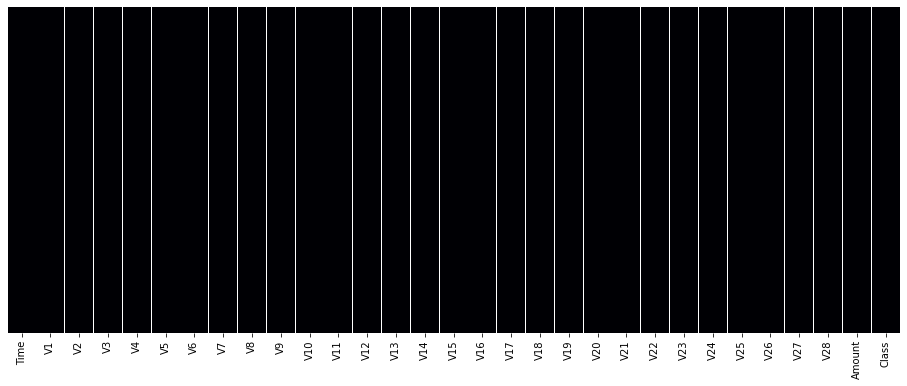

In [8]:
plt.figure(figsize=(16, 6))
sns.heatmap(df_m.isnull(), yticklabels=False, cbar=False, cmap='magma')

## Variable split ##

In [0]:
X = df_m.drop('Class', axis=1)
y = df_m['Class']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Logistic Regression ##

In [0]:
logmodel = LogisticRegression(max_iter=1000)

logmodel.fit(X_train, y_train) # train
lr_pred = logmodel.predict(X_test) # test

In [12]:
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85281
           1       0.87      0.62      0.73       162

    accuracy                           1.00     85443
   macro avg       0.93      0.81      0.86     85443
weighted avg       1.00      1.00      1.00     85443



In [13]:
print(confusion_matrix(y_test, lr_pred))

[[85266    15]
 [   61   101]]


## Decision Tree ##

In [0]:
dtree = DecisionTreeClassifier()

dtree.fit(X_train, y_train) # train
dt_pred = dtree.predict(X_test) # test

In [15]:
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85281
           1       0.78      0.77      0.77       162

    accuracy                           1.00     85443
   macro avg       0.89      0.89      0.89     85443
weighted avg       1.00      1.00      1.00     85443



In [16]:
print(confusion_matrix(y_test, dt_pred))

[[85245    36]
 [   37   125]]


## Random Forest Classifier ##

In [0]:
rfc = RandomForestClassifier(n_estimators=300)

rfc.fit(X_train, y_train) # train
rfc_pred = rfc.predict(X_test) # test

In [18]:
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85281
           1       0.96      0.81      0.88       162

    accuracy                           1.00     85443
   macro avg       0.98      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443



In [19]:
print(confusion_matrix(y_test, rfc_pred))

[[85275     6]
 [   30   132]]


## Cost-sensitive Logistic Regression ##

In [0]:
cost_mat_train = np.zeros((len(y_train),4))
#false positives cost 5
cost_mat_train[:,0]=5
#false negatives cost the transaction amount
cost_mat_train[:,1]=X_train['Amount']
#true positives also cost 5
cost_mat_train[:,2]=5
 
cost_mat_test = np.zeros((len(y_test),4))
cost_mat_test[:,0]=5
cost_mat_test[:,1]=X_test['Amount']
cost_mat_test[:,2]=5

In [27]:
f = CostSensitiveLogisticRegression()
f.fit(np.array(X_train),np.array(y_train), cost_mat_train)
y_pred_logistic_cslr = f.predict(X_test)

/usr/local/lib/python3.6/dist-packages/costcla/models/regression.py:45: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


In [0]:
# g = CostSensitiveRandomForestClassifier()
# g.fit(np.array(X_train), np.array(y_train), cost_mat_train)
# y_pred_rf_cslr=g.predict(np.array(X_test))

In [0]:
h = CostSensitiveDecisionTreeClassifier()
h.fit(np.array(X_train), np.array(y_train), cost_mat_train)
y_pred_tree_cslr = h.predict(np.array(X_test))

In [33]:
print('logistic: cost sensitve learning')
print(cost_loss(y_test,y_pred_logistic_cslr,cost_mat_test))
print('decision tree: cost sensitve learning')
print(cost_loss(y_test,y_pred_tree_cslr,cost_mat_test))

logistic: cost sensitve learning
7958.55
decision tree: cost sensitve learning
2159.8900000000003
